In [37]:
import pandas as pd
import pandas
import numpy as np
import praw
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import gc
from sklearn import preprocessing

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

<h2>
    <center>
        Words as Predictors for Positivity or Negativity in Comments
    </center>
</h2>
<p>
This segment will analyze the frequency of words that appear in the most positively and negatively scored comments from Reddit. The two nltk package downloads are required to tag individual words to their part of speech. This allows us to filter the words we do not believe are relevant to a post's popularity. The hypothesis being tested is whether there exists a relationship or effect of the semantics of words and the resulting positivity or negativity score a message receives. This serves to establish if certain key words exist that would tend to make an audience like or dislike comments disproportionately more than other words. Likewise, the experiment will serve as an algorithm that could potentially score words based on this positivity or negativity rating.
</p>

<h3><center>Setup</center></h3>
The word maps will contain every instance of a valid word within the comment texts. The pos_map is a list of parts of speech that will be included in the filtering for our word table.

List with examples
<ul>
  <li>JJ adjective 'big'
</li>
  <li>JJR adjective, comparative 'bigger'
</li>
  <li>JJS adjective, superlative 'biggest'
</li>
  <li>NN noun, singular 'desk'
</li>
  <li>NNS noun plural 'desks'
</li>
  <li>NNP proper noun, singular 'Harrison'
</li>
   <li>NNPS proper noun, plural 'Americans'
</li>
  <li>RB adverb very, silently,
</li>
  <li>RBR adverb, comparative better
</li>
   <li>RBS adverb, superlative best
</li>
  <li>RP particle give up
</li>
  <li>UH interjection errrrrrrrm
</li>
   <li>VB verb, base form take
</li>
  <li>VBD verb, past tense took
</li>
  <li>VBG verb, gerund/present participle taking
</li>
   <li>VBN verb, past participle taken
</li>
  <li>VBP verb, sing. present, non-3d take
</li>
  <li>VBZ verb, 3rd person sing. present takes
</li>
</ul>

The regular expression will filter out all nonalphanumeric characters. The natural language toolkit's tokenizer splits words into tokens based on their criteria for parts of speech. This separates words that have nonalphanumeric characters between them like a hyphen. This is not favorable, since it also allows duplicate words with differing capitalizations within the word. The regular expression will ensure that all words are split on space, and each word does not contain nonsense characters. The filter for these parts of speech is used to more accurately select real english words.

In [2]:
pos_word_map = []
neg_word_map = []
pos_map = ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "RB", "RBR", "RBS", "RP","UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
pattern = re.compile('[\W_]+', re.UNICODE)

<br/>
<h3>
    <center>
    Preprocessing the Data for Word Analysis
    </center>
    </h3>

This section of code iterates through the positive comment table and copies instances of valid words to the pos_word_map as a tuple of it and the corresponding comment score. This will allow us to measure the relative score of a word in relation to the score of the comments it appears in. Every single word within the text will be assigned the point value of the post it came from, and words that appear multiple times within the text will be weighted with multiple of these assignments. This will increase the positive or negative predictor score of words based on their frequency in high or low scoring points. 

In [3]:
for i, row in posjson.iterrows():
    text = row.text
    new_text = text.split()
    results = []
    score = row.score
    for word in new_text:
        temp = pattern.sub('', word).lower()
        if temp != '':
            results.append((temp,score))
    pos_word_map.extend(results)

<br>
The rest of the code sections are intermediary steps in creating a cleaned up DataFrame which we can work with. The DataFrames are manipulated in order to translate the information from a word, score tuple Series into a DataFrame. Two DataFrames are then needed in order to cleanly sum up the frequency of each word within the entire corpus of reddit comments for the json records as well as the associated score for each word. The following show the process as these mappings are produced.

In [4]:
#Creates a DataFrame for the word,score tuples
pos_tokens_df = pd.DataFrame(pos_word_map, columns = ['word', 'score'])

In [5]:
#Creates a DataFrame with the frequency of each word in the total pos_word_map
pos_count_df = pd.DataFrame(pos_tokens_df.word.value_counts())
pos_count_df.reset_index(level=0, inplace=True)
pos_count_df.rename(columns={"index":"word", "word":"frequency"}, inplace=True)
pos_count_df.head(10)

,word,frequency
0,the,209834
1,a,137305
2,to,136102
3,i,123571
4,and,119350
5,of,92023
6,you,77556
7,that,72116
8,in,68963
9,it,67261


In [6]:
#Creates a DataFrame for the positively scored words where the raw score is the sum of all of the instances of a word's 
#post score
pos_score_df = pd.DataFrame(pos_word_map)
pos_score_df = pd.DataFrame(pos_score_df)
pos_score_df.reset_index(level=0, inplace=True)
pos_score_df = pd.DataFrame(pos_score_df.groupby(0)[1].sum())
pos_score_df.reset_index(level=0, inplace=True)
pos_score_df.rename(columns={0:"word",1:"raw_score"},inplace=True)
pos_score_df.head(10)

,word,raw_score
0,0,289378
1,00,20749
2,000,32023
3,0000,2884
4,000000,4247
5,00000000000000001,488
6,00000014658994266,555
7,0000002191397973,1110
8,000000httpwwwcolorhexcomcolor000000,940
9,000001,3382


<br>
As seen above, the data contains a significant number of words that do not have any meaning in either English or in the context of comment score preditions. These words will be filtered out in a couple of steps. The frequency of each word was initially calculated in order to assist with removing words that appear to have no significance or words that may bias the data too much due to outlier posts that contain infrequently used words.

In [7]:
#Creates a DataFrame with the average score of each word as the raw_score / word frequency
pos_df = pos_count_df.set_index('word').join(pos_score_df.set_index('word'), rsuffix='_r')
pos_df.reset_index(level=0, inplace=True)
pos_df.rename(columns={"score_r":"score"}, inplace=True)
pos_df['average_score'] = pos_df.raw_score / pos_df.frequency
pos_df.head(10)

,word,frequency,raw_score,average_score
0,the,209834,178387402,850.135831
1,a,137305,116328938,847.230166
2,to,136102,115902558,851.586002
3,i,123571,105821196,856.359469
4,and,119350,102588381,859.559120
5,of,92023,78011596,847.740195
6,you,77556,66751145,860.683184
7,that,72116,60539661,839.476136
8,in,68963,58953207,854.852704
9,it,67261,57005025,847.519737


<br>
It is in this step that the natural language toolkit is used in order to tag each word parsed in the previous segments with the part of speech the word belongs to. This allows us to choose only words from the list of parts of speech as valid entries in the DataFrame. Filtering out words that might either not be English or removing statistical outliers from appearing only a handful of times will make the data more accurate in predicting positively and negatively biased words. The frequency filter was set to 50 after determining a safeguard buffer for words that did not appear to make any sense.

In [8]:
#Creates a DataFrame with the part of speech for each word added
pos_df = pos_df[pos_df.frequency > 50]
pos_tags = nltk.pos_tag(pos_df.word)
pos_tags = pd.DataFrame(pos_tags)
pos_df['part_of_speech'] = pos_tags[1]
pos_df = pos_df[pos_df.part_of_speech.isin(pos_map)]
pos_df = pd.DataFrame(pos_df)
pos_df.reset_index(level=0,drop=True,inplace=True)
pos_df.head()

,word,frequency,raw_score,average_score,part_of_speech
0,i,123571,105821196,856.359469,NN
1,is,61584,51719699,839.823639,VBZ
2,was,47110,40223608,853.823137,VBD
3,have,30279,25534513,843.307672,NN
4,be,28346,23870140,842.099062,VB


<br/>
It is important to clean up the dataframes that are no longer in use, because the overhead for maintaining the dataframes and arrays in memory are too high. This may cause the kernal to terminate.


In [9]:
#Cleanup for memory
del pos_tokens_df, pos_score_df, pos_word_map, pos_count_df, pos_tags
gc.collect()

34

<br>
<h3>
    <center>
    This section of code will replicate the upper section with regard to the most negatively scored comments.
    </center>
</h3>

In [10]:
for i, row in negjson.iterrows():
    text = row.text
    new_text = text.split()
    results = []
    score = row.score
    for word in new_text:
        temp = pattern.sub('', word).lower()
        if temp != '':
            results.append((temp,score))
    neg_word_map.extend(results)

In [11]:
#Creates a DataFrame for the word,score tuples
neg_tokens_df = pd.DataFrame(neg_word_map, columns = ['word', 'score'])

In [12]:
#Creates a DataFrame with the frequency of each word in the total pos_word_map
neg_count_df = pd.DataFrame(neg_tokens_df.word.value_counts())
neg_count_df.reset_index(level=0, inplace=True)
neg_count_df.rename(columns={"index":"word", "word":"frequency"}, inplace=True)
neg_count_df.head(10)

,word,frequency
0,the,189783
1,to,140089
2,a,134658
3,you,114409
4,i,108607
5,and,106129
6,of,91741
7,is,82551
8,that,79801
9,it,70022


In [13]:
#Creates a DataFrame for the negatively scored words where the raw score is the sum of all of the instances of a word's 
#post score
neg_score_df = pd.DataFrame(neg_word_map)
neg_score_df = pd.DataFrame(neg_score_df)
neg_score_df.reset_index(level=0, inplace=True)
neg_score_df = pd.DataFrame(neg_score_df.groupby(0)[1].sum())
neg_score_df.reset_index(level=0, inplace=True)
neg_score_df.rename(columns={0:"word",1:"raw_score"},inplace=True)
neg_score_df.head(10)

,word,raw_score
0,0,-17361
1,00,-1407
2,000,-804
3,0000,-34
4,00000000000000000000000000001,-75
5,000000000001,-70
6,00000000000ooooooo00000o0k0kkkkkkk000kkkkkkxkk...,-41
7,00000000001,-49
8,0000000001,-65
9,00000001676,-40


In [14]:
#Creates a DataFrame with the average score of each word as the raw_score / word frequency
neg_df = neg_count_df.set_index('word').join(neg_score_df.set_index('word'), rsuffix='_r')
neg_df.reset_index(level=0, inplace=True)
neg_df.rename(columns={"score_r":"score"}, inplace=True)
neg_df['average_score'] = neg_df.raw_score / neg_df.frequency
neg_df.head(10)

,word,frequency,raw_score,average_score
0,the,189783,-9192689,-48.437895
1,to,140089,-6892504,-49.200894
2,a,134658,-6624772,-49.197018
3,you,114409,-5642931,-49.322440
4,i,108607,-5520607,-50.831042
5,and,106129,-5234321,-49.320365
6,of,91741,-4497583,-49.024787
7,is,82551,-4016658,-48.656685
8,that,79801,-3857343,-48.337026
9,it,70022,-3415431,-48.776542


In [15]:
#Creates a DataFrame with the part of speech for each word added
neg_df = neg_df[neg_df.frequency > 50]
neg_tags = nltk.pos_tag(neg_df.word)
neg_tags = pd.DataFrame(neg_tags)
neg_df['part_of_speech'] = neg_tags[1]
neg_df = neg_df[neg_df.part_of_speech.isin(pos_map)]
neg_df = pd.DataFrame(neg_df)
neg_df.reset_index(level=0,drop=True,inplace=True)
neg_df.head()

,word,frequency,raw_score,average_score,part_of_speech
0,i,108607,-5520607,-50.831042,JJ
1,is,82551,-4016658,-48.656685,VBZ
2,not,44253,-2156621,-48.733894,RB
3,are,41097,-2000903,-48.687325,VBP
4,have,35133,-1719123,-48.931859,VB


In [35]:
#Cleanup for memory
del neg_tokens_df, neg_score_df, neg_word_map, neg_count_df, neg_tags
gc.collect()

NameError: name 'neg_tokens_df' is not defined

<br>
<h3><center>Exploratory Data Analysis of Word Processing</center></h3>
Now that the data has been organized for preprocessing, we take the sklearn modules to normalize and standardize the data on each of the numeric columns for both the pos_df and neg_df DataFrames. The most important columns to look at are the normalized and standardized average scores, since this represents the relationship between frequency of the word and the word's raw score. The normalization and standardization allow us to make statisical observations about certain words relative to other words in the data set.

In [17]:
df_num_pos = pos_df.select_dtypes(include=[np.number])
df_num_neg = neg_df.select_dtypes(include=[np.number])
df_num_neg = df_num_neg.abs()

min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()
pos_df = pos_df.join(pd.DataFrame(min_max_scaler.fit_transform(df_num_pos), columns=df_num_pos.columns, 
                                  index=df_num_pos.index), rsuffix='_normalized')
neg_df = neg_df.join(pd.DataFrame(min_max_scaler.fit_transform(df_num_neg), columns=df_num_neg.columns, 
                                  index=df_num_neg.index), rsuffix='_normalized')
pos_df = pos_df.join(pd.DataFrame(standard_scaler.fit_transform(df_num_pos), columns=df_num_pos.columns, 
                                  index=df_num_pos.index), rsuffix='_standardized')
neg_df = neg_df.join(pd.DataFrame(standard_scaler.fit_transform(df_num_neg), columns=df_num_neg.columns, 
                                  index=df_num_neg.index), rsuffix='_standardized')

<br>
This graph shows the normalized average score for both the words in the top 180,000 positive comments in green and the words in the top 180,000 negative comments in orange. The negatively scored words were normalized with their absolute value to present data that can be directly comparable to the positive words.

Positive Comments (Mean Normalized) : 0.28008082343117385
Positive Comments (Std Normalized)  : 0.056089986060775344
Negative Comments (Mean Normalized) : 0.1916416594980063
Negative Comments (Std Normalized)  : 0.05126448111777192
Difference (Mean Normalized)        : 0.08843916393316756
Difference (Std Normalized)         : 0.004825504943003427


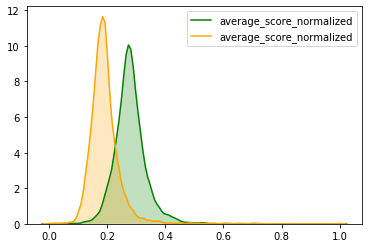

In [18]:
sns.kdeplot(pos_df.average_score_normalized, shade=True, color='Green')
sns.kdeplot(neg_df.average_score_normalized, shade=True, color='Orange')
print("Positive Comments (Mean Normalized) : " + str(pos_df.average_score_normalized.mean()))
print("Positive Comments (Std Normalized)  : " + str(pos_df.average_score_normalized.std()))
print("Negative Comments (Mean Normalized) : " + str(neg_df.average_score_normalized.mean()))
print("Negative Comments (Std Normalized)  : " + str(neg_df.average_score_normalized.std()))
print("Difference (Mean Normalized)        : " + str(pos_df.average_score_normalized.mean() - neg_df.average_score_normalized.mean()))
print("Difference (Std Normalized)         : " + str(pos_df.average_score_normalized.std() - neg_df.average_score_normalized.std()))

<br>
The second graph plots the standardized average scores for the positive and negative words. With the data standardized, we can now compare the words across positive and negative DataFrames to determine which words are the most positive, neutral, or negative by frequency and comment score.

Positive Comments (Mean Standardized) : -1.1752844814445877e-15
Positive Comments (Std Standardized)  : 1.0000840159631812
Negative Comments (Mean Standardized) : -7.201027201482756e-16
Negative Comments (Std Standardized)  : 1.0000873782167774
Difference (Mean Standardized)        : -4.551817612963122e-16
Difference (Std Standardized)         : -3.3622535962063438e-06


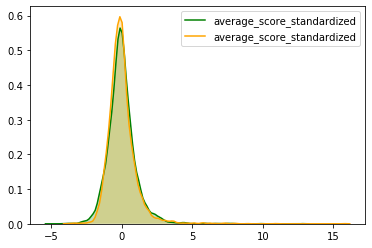

In [19]:
sns.kdeplot(pos_df.average_score_standardized, shade=True, color='Green')
sns.kdeplot(neg_df.average_score_standardized, shade=True, color='Orange')
print("Positive Comments (Mean Standardized) : " + str(pos_df.average_score_standardized.mean()))
print("Positive Comments (Std Standardized)  : " + str(pos_df.average_score_standardized.std()))
print("Negative Comments (Mean Standardized) : " + str(neg_df.average_score_standardized.mean()))
print("Negative Comments (Std Standardized)  : " + str(neg_df.average_score_standardized.std()))
print("Difference (Mean Standardized)        : " + str(pos_df.average_score_standardized.mean() - neg_df.average_score_standardized.mean()))
print("Difference (Std Standardized)         : " + str(pos_df.average_score_standardized.std() - neg_df.average_score_standardized.std()))

<br>
This chart shows the top 10 words by average standardized score for positive comments. The distribution skews long tails where the score is many standard deviations above the mean. This can be attributed to the fact that these data sets take a look at the top/lowest 180,000 comments by score out of a dataset that contains 380 million comments. By eliminating the majority of neutrally voted comments by absolute value, some words will be heavily biased due to their low frequency count in relation to their appearance in some highly scored points, whether they be positive or negative. This means that given analysis of enough data points it is highly likely for those top 9 words to fall in the rankings, since the top 9 also comprise entirely out of words that rank below 3700 on their frequency within the corpus.

In [20]:
pos_df.sort_values(by="average_score_standardized", ascending=False).head(10)

,word,frequency,raw_score,average_score,part_of_speech,frequency_normalized,raw_score_normalized,average_score_normalized,frequency_standardized,raw_score_standardized,average_score_standardized
4754,shrimp,69,125890,1824.492754,NN,0.000146,0.000882,1.000000,-0.169317,-0.135342,12.836153
4332,gilded,78,124731,1599.115385,VBD,0.000219,0.000871,0.833503,-0.165475,-0.135923,9.867518
5310,thor,59,88902,1506.813559,NN,0.000065,0.000532,0.765316,-0.173586,-0.153893,8.651732
4723,wasps,69,99922,1448.144928,NN,0.000146,0.000636,0.721974,-0.169317,-0.148366,7.878958
4944,pucker,65,93365,1436.384615,NN,0.000113,0.000574,0.713286,-0.171024,-0.151654,7.724053
5232,currency,60,85352,1422.533333,NN,0.000073,0.000498,0.703054,-0.173159,-0.155673,7.541606
5227,bloat,60,84753,1412.550000,NN,0.000073,0.000493,0.695679,-0.173159,-0.155974,7.410107
4657,mold,71,97765,1376.971831,JJ,0.000162,0.000616,0.669395,-0.168463,-0.149448,6.941477
3764,glitter,93,126456,1359.741935,VBP,0.000340,0.000887,0.656667,-0.159073,-0.135058,6.714528
324,gold,1403,1887736,1345.499644,JJ,0.010946,0.017536,0.646146,0.400104,0.748311,6.526930


In [21]:
neg_df.sort_values(by="average_score_standardized", ascending=False).head(10)

,word,frequency,raw_score,average_score,part_of_speech,frequency_normalized,raw_score_normalized,average_score_normalized,frequency_standardized,raw_score_standardized,average_score_standardized
4790,diversity,64,-8973,-140.203125,NN,0.000120,0.001293,1.000000,-0.180648,-0.132076,15.769768
2816,inferior,135,-15121,-112.007407,JJ,0.000774,0.002407,0.750928,-0.152134,-0.082336,10.910777
3037,poverty,120,-12046,-100.383333,NN,0.000636,0.001850,0.648245,-0.158158,-0.107214,8.907590
5048,leftist,60,-5763,-96.050000,JJ,0.000083,0.000712,0.609965,-0.182255,-0.158047,8.160824
4832,edit3,63,-5970,-94.761905,JJ,0.000111,0.000749,0.598587,-0.181050,-0.156372,7.938845
96,ha,4617,-436853,-94.618367,VBP,0.042061,0.078825,0.597319,1.647853,3.329675,7.914109
4381,ours,73,-6700,-91.780822,NNS,0.000203,0.000881,0.572253,-0.177034,-0.150466,7.425113
4779,frequent,64,-5847,-91.359375,JJ,0.000120,0.000727,0.568530,-0.180648,-0.157367,7.352484
5508,chuckle,53,-4831,-91.150943,NN,0.000018,0.000543,0.566689,-0.185066,-0.165587,7.316565
4837,stores,63,-5692,-90.349206,NNS,0.000111,0.000699,0.559607,-0.181050,-0.158621,7.178401


<br>
The words from the positive and negative lists are combined to get the standardized score accounting for the difference between the positive commends and negative comments. This segment takes the union of both positive and negative DataFrames and merges the records to find the difference between the average standardized score for each word. The set of words not in the union are then added to the final DataFrame. The negatively standardized data is appropriately modified to reflect the negativity of the words by taking the opposite sign. This is because the standardization was originally representing how negative the word was as  a positive value, but now that we are comparing it to the positivity of the words in the positive word DataFrame, this difference must be reflected in its sign.

In [22]:
inner_join = pd.merge(left=pos_df, right=neg_df, left_on='word',right_on='word')

In [23]:
left = pos_df.loc[np.logical_not(pos_df.word.isin(neg_df.word))]
right = neg_df.loc[np.logical_not(neg_df.word.isin(pos_df.word))]
right[right.select_dtypes(include=[np.number]).columns] *= -1
diff_join = pd.DataFrame(inner_join.word)
diff_join['diff_standardized_score'] = inner_join.average_score_standardized_x - inner_join.average_score_standardized_y
left.rename(columns={"average_score_standardized":"diff_standardized_score"}, inplace=True)
right.rename(columns={"average_score_standardized":"diff_standardized_score"}, inplace=True)
diff_df = pd.concat([diff_join, left[["word","diff_standardized_score"]], right[["word","diff_standardized_score"]]])
diff_df.sort_values(by="diff_standardized_score", ascending=False,inplace=True)
diff_df.reset_index(level=0, drop=True, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


<br>
Because we have combined both standardized lists and accounted for the negative words as negative values, the distribution looks similar to the one above. The difference in negative values caused the graph to become mirrored on approxmiately x = 0. This should be expected, since the graphs above were similar to each other, and the DataFrame manipulation only mapped to the difference between the two. This reflects the overall minimal change between both the positive and negative word DataFrames.

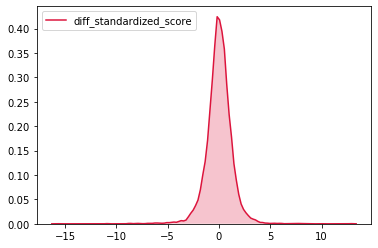

In [24]:
sns.kdeplot(diff_df.diff_standardized_score, shade=True, color='crimson')

<br>This is a list of the top 15 words that predict a positive scoring comment.

In [25]:
diff_df.head(15)

,word,diff_standardized_score
0,shrimp,12.836153
1,gilded,9.867518
2,thor,8.651732
3,currency,8.265685
4,wasps,7.878958
5,pucker,7.724053
6,bloat,7.410107
7,mold,6.941477
8,glitter,6.714528
9,pat,6.053484


<br>This is a list of the top 15 words that predict a negative scoring comment.

In [26]:
diff_df.tail(15)

,word,diff_standardized_score
7034,rpics,-6.250185
7035,stores,-6.475141
7036,gem,-6.649787
7037,frequent,-6.839013
7038,jay,-6.905469
7039,mexicans,-7.053245
7040,iama,-7.563214
7041,ha,-7.845296
7042,edit3,-7.938845
7043,leftist,-8.160824


<br>
This is a list of the 10 words on both sides of standardized 0, which should indicate words that are neutral in predicting the positive or negative score of a comment.

In [27]:
diff_df.loc[3559:3579]

,word,diff_standardized_score
3559,incorrectly,-0.001261
3560,parents,-0.001478
3561,sucked,-0.001481
3562,languages,-0.001936
3563,hyperbole,-0.002108
3564,sherlock,-0.002148
3565,wars,-0.002153
3566,gtthe,-0.002238
3567,disrespect,-0.002874
3568,ruled,-0.002885


<h2><center>Conclusion</center></h2>

The texts for approximately 360,000 comments, 180,000 of which were the most positively scored and 180,000 of which were the most negatively scored comments, were analyzed to explore the relationship between the text of a Reddit post and the score the comment received. The overarching motivation behind this was to test a hypothesis determining the relationship of words and their corresponding positive or negative connotations and seeing if there is a significant correlation between the words used in a Reddit post and the score a Reddit post receives. Rather expectedly, the distrbution of word frequencies skewed heavily towards the left on a distribution plot, indicating that the majority of the words used on Reddit are comprised of a small subset of the entire language. While tidying up the data for word analysis, there were approximately 5.3 million individual words within the text of the 180,000 most positively scored comments alone. The 5.3 million words comprised of approximately 125,000 unique words, with over 80% of the words being cut due to less than 50 unique appearances or for being from a relatively small subset of common words like pronouns, articles or the like. Together with the list compiled for the negative comments, the final list of words came out to around 7,000 unique words. Due to the standaridization, the data set should fit the 68-95-99.7 rule. When looking at the normalized data, the average mean word score for positive words was approximately 28% of the maximum value, while the mean word score for negative words was approximately 19% of the maximum. Both had similar standard deviations of 5.6% and 5.1% of the maxmimum average value. The majority of values fell within the few standard deviations, but due to the relatively sparse nature of the data, a few word became major outliers. One way to curb outliers of this nature are to either expand the scope of the dataset to significantly higher than the 360,000 used in this experiment or to randomly select from the population of comments that exist on reddit to reduce the likelihood of these events.

After coming up with the list of words that comprise the top 15 most positive and negative words, it can be seen that negatively correlated words tended to have a negative connotation in respect to the English language, while the positively correlated words tended to be more random. The 20 most neutral words spanned 10 words from 0 in the distrbution, and these words tended to have a fairly neutral connotation. As a result, it may be possible that words that are highly positively correlated on this list made it to the top due to the small sample size, and the negative words that made it onto the list had their negative score amplified by the small sample size as well. The difference between the connotation of the positive and negative words seemed to be that the positive scores were on average 17 times higher with an average of around 850, while the negative words had an average of approximately -50. The positive comments score positive significantly higher than negative comments scored negative. Even with a low negative mean, the largest standard deviation words eclipsed what is statistically probable, and that is again attributed to the sample size not being able to encompass the dictionary of words as well with only 360,000 non random comments. Analysis of the positivity and negativity of words resulted in list of words that may be able to predict the direction of a comment's score, but the variability of the score's magnitude would not be able to be determined.